# Customer Segmentation
## K-Means Clustering and Segment Profiling

This notebook builds a simple customer segmentation using K-Means and profiles each segment.

Steps:
1. Load data
2. Choose number of clusters
3. Fit K-Means
4. Profile segments
5. Save results

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import joblib

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

print("Libraries loaded successfully!")

Libraries loaded successfully!


## 1. Load Data

In [2]:
# Paths
PROCESSED_PATH = Path("../data/processed")
RAW_PATH = Path("../data/raw")
MODELS_PATH = Path("../models")
MODELS_PATH.mkdir(parents=True, exist_ok=True)

# Load scaled features (for clustering)
X_train_scaled = pd.read_csv(PROCESSED_PATH / "X_train_scaled.csv")
X_test_scaled = pd.read_csv(PROCESSED_PATH / "X_test_scaled.csv")

# Drop ID columns if present
cols_to_drop = ['CustomerId', 'Surname', 'RowNumber']
for col in cols_to_drop:
    if col in X_train_scaled.columns:
        X_train_scaled = X_train_scaled.drop(columns=[col])
        X_test_scaled = X_test_scaled.drop(columns=[col])
        print(f"Dropped '{col}' from features")

# Ensure all columns are numeric
non_numeric_cols = X_train_scaled.select_dtypes(include=['object']).columns.tolist()
if non_numeric_cols:
    print(f"Dropping non-numeric columns: {non_numeric_cols}")
    X_train_scaled = X_train_scaled.drop(columns=non_numeric_cols)
    X_test_scaled = X_test_scaled.drop(columns=non_numeric_cols)

# Combine train and test for clustering
X_scaled_full = pd.concat([X_train_scaled, X_test_scaled], axis=0).reset_index(drop=True)

# Load raw data for profiling
raw_df = pd.read_csv(RAW_PATH / "Churn_Modelling.csv")

print("Data loaded successfully!")
print("=" * 50)
print(f"Scaled feature matrix: {X_scaled_full.shape}")
print(f"Raw data: {raw_df.shape}")

Dropped 'CustomerId' from features
Dropped 'Surname' from features
Data loaded successfully!
Scaled feature matrix: (10000, 36)
Raw data: (10000, 14)


## 2. Choose Number of Clusters

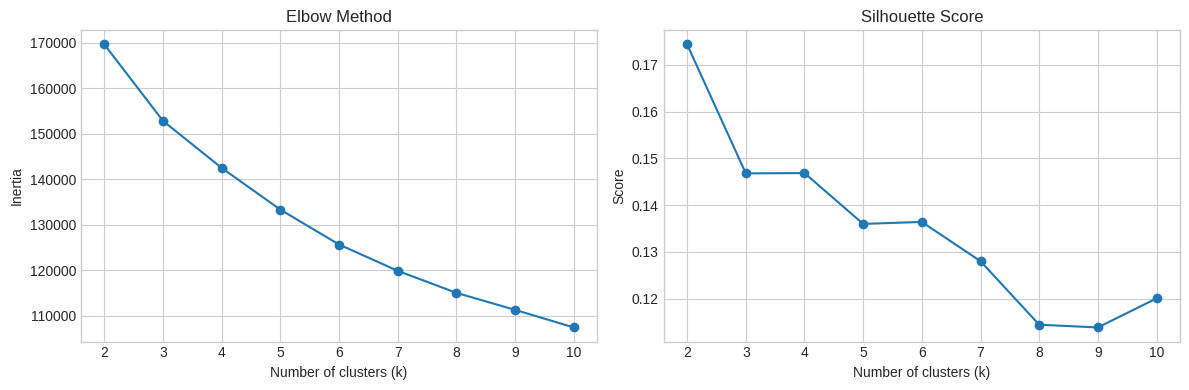

Best k by silhouette: 2


In [3]:
# Evaluate cluster counts using inertia and silhouette
k_values = range(2, 11)

inertias = []
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled_full)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled_full, kmeans.labels_))

# Plot elbow and silhouette
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(list(k_values), inertias, marker='o')
axes[0].set_title('Elbow Method')
axes[0].set_xlabel('Number of clusters (k)')
axes[0].set_ylabel('Inertia')

axes[1].plot(list(k_values), silhouette_scores, marker='o')
axes[1].set_title('Silhouette Score')
axes[1].set_xlabel('Number of clusters (k)')
axes[1].set_ylabel('Score')

plt.tight_layout()
plt.show()

best_k = k_values[int(np.argmax(silhouette_scores))]
print(f"Best k by silhouette: {best_k}")

## 3. Fit K-Means and Assign Segments

In [4]:
# Fit final model
k_final = best_k
kmeans_final = KMeans(n_clusters=k_final, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_scaled_full)

# Attach segment labels to raw data
segmented_df = raw_df.copy().reset_index(drop=True)
segmented_df['Segment'] = cluster_labels

print(f"Assigned {k_final} clusters to {segmented_df.shape[0]} customers")

Assigned 2 clusters to 10000 customers


## 4. Segment Profiling

In [5]:
# Basic segment summary
segment_counts = segmented_df['Segment'].value_counts().sort_index()
print("Segment sizes:")
print(segment_counts)

# Profile numeric features by segment
numeric_cols = segmented_df.select_dtypes(include='number').columns.tolist()

# Remove target and IDs from profiling
exclude_cols = {'Exited', 'RowNumber', 'CustomerId'}
profile_cols = [c for c in numeric_cols if c not in exclude_cols]

segment_profile = segmented_df.groupby('Segment')[profile_cols].mean().round(3)
print("\nSegment profile (mean values):")
segment_profile

Segment sizes:
Segment
0    6189
1    3811
Name: count, dtype: int64

Segment profile (mean values):


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Segment
Segment,,,,,,,,,
0,650.656,38.931,5.046,76089.427,1.525,0.709,0.520,100584.884,0.0
1,650.322,38.906,4.959,77129.737,1.539,0.701,0.507,99286.946,1.0


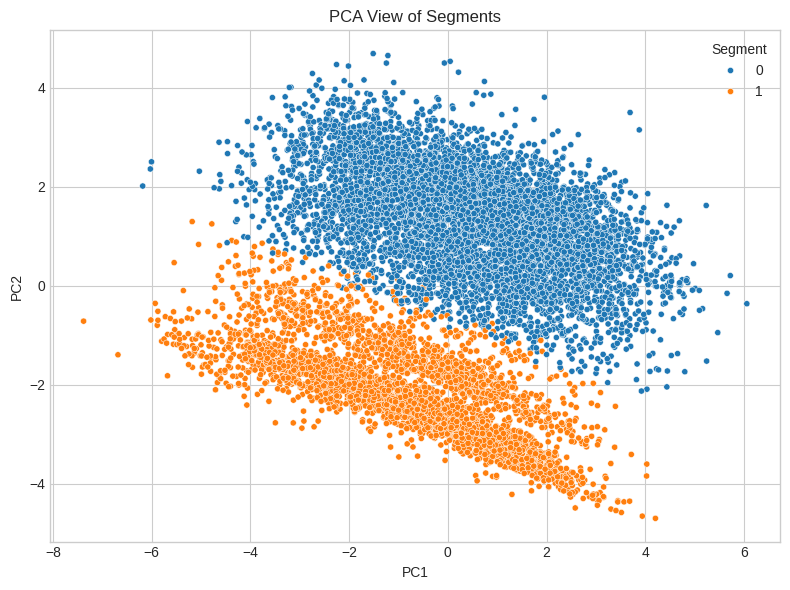

In [6]:
# Visualize segments with PCA (2D)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled_full)

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['Segment'] = cluster_labels

plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Segment', palette='tab10', s=20)
plt.title('PCA View of Segments')
plt.tight_layout()
plt.show()

## 5. Save Results

In [7]:
# Save artifacts
segmented_df.to_csv(PROCESSED_PATH / "segmentation_labels.csv", index=False)
segment_profile.to_csv(PROCESSED_PATH / "segment_profile.csv")
joblib.dump(kmeans_final, MODELS_PATH / "kmeans_segmentation.pkl")

print("Saved:")
print(" - data/processed/segmentation_labels.csv")
print(" - data/processed/segment_profile.csv")
print(" - models/kmeans_segmentation.pkl")

Saved:
 - data/processed/segmentation_labels.csv
 - data/processed/segment_profile.csv
 - models/kmeans_segmentation.pkl
